In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import gensim
import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [ ]:
CONSTANTS = {
    'label': 'default payment next month',
    'path': 'preprocessed_upsampled.csv',
    'sequence_features': ['PAY_', 'BILL_AMT', 'PAY_AMT'],
    'non_sequence_features': ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'],
    'length': 6,
    'batch_size': 64,
}

In [ ]:
class Dataset_seq(Dataset):
  def __init__(self, path):
    self.data = pd.read_csv(path)
    self.label = CONSTANTS['label']
    self.features = list(self.data.columns)
    self.features.remove(self.label)
  
  def __getitem__(self, index):
    ex = self.data.iloc[index]
    label = ex[self.label]
    features = ex[self.features]

    non_sequential_features = list(features[CONSTANTS['non_sequence_features']].values)

    all_features = []

    for i in range(1, 1 + CONSTANTS['length']):
      seq_i = []
      for base_feature in CONSTANTS['sequence_features']:
        seq_i.append(features[f'{base_feature}{i}'])
      
      seq_i += non_sequential_features
      all_features.append(seq_i)
    
    all_features = np.array(all_features)
    all_features = all_features.astype(np.double)
    all_features = torch.from_numpy(all_features)

    all_features = all_features.type(torch.float)

    return torch.flatten(all_features), torch.tensor(label, dtype=torch.long)
  
  def __len__(self):
    return self.data.shape[0]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = Dataset_seq(CONSTANTS['path'])

# Single Layer LSTM

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
# Define RNN

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden = 150
        self.layers = 1
        self.lstm = nn.LSTM(input_size=48,hidden_size=self.hidden,num_layers=self.layers)
        self.linear = nn.Linear(self.hidden,2)
        self.relu = nn.ReLU()

    def forward(self, x, h, c):
        out,(h,c) = self.lstm(x,(h,c))
        
        out = self.linear(out)
        # out = self.relu(out)
        return out,h,c

    def init_h(self, bsz):
        weight = next(self.parameters())
        return weight.new_zeros(self.layers, self.hidden)

    def init_c(self, bsz):
        weight = next(self.parameters())
        return weight.new_zeros(self.layers, self.hidden)

Using cuda device


In [ ]:
# Define Loss, Optimizer
model = NeuralNetwork()
model = model.to(device)
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)



In [ ]:
# Training 
batch_sz = CONSTANTS['batch_size']
data_size = len(data)
train_set, valid_set = random_split(data, [24000, 6000])

train_loader = DataLoader(train_set, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(valid_set, batch_size=batch_sz, shuffle=True)
# total_loader = DataLoader(data,batch_size = batch_sz, shuffle=True)

In [ ]:
# train_loader = total_loader

def train():
  
  h = model.init_h(batch_sz)
  c = model.init_c(batch_sz)

  epochs = 30

  training_loss = []
  training_error = []
  val_loss = []
  val_error = []
  for epoch in range(epochs):
    model.train()
    start_time = time.time()
    running_loss = 0
    correct = 0
    flag = 0

    if epoch > 8 and flag == 0:
      for op_params in optimizer.param_groups:
        op_params['lr'] = 1e-4
        flag = 1
    
    if epoch > 15 and flag == 1:
      for op_params in optimizer.param_groups:
        op_params['lr'] = 1e-5
        flag = 2
    

    for input,label in train_loader:

        input = input.to(device)
        label = label.to(device)
        model.zero_grad()
        h = h.detach()
        c = c.detach()
        output, h, c = model(input, h, c)
        output = output.to(device)

        loss = criterion(output, label)

        _, pred = torch.max(output, 1)
        correct += (pred == label).float().sum().detach().cpu()
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()

        running_loss += loss.item()

    # print(correct)
    # print(len(train_loader)*batch_sz)
    training_loss.append(running_loss/(len(train_loader)))
    training_error.append(1 - (correct/(len(train_loader)*batch_sz)))
    print('Epoch [{}/{}], Training Loss: {:.4f}, Training Error: {:.4f}'.format(epoch+1, epochs, running_loss/(len(train_loader)), 1 - (correct/(len(train_loader)*batch_sz))))




  # # Calculate validation loss and error after each epoch

    model.eval()
    val_correct = 0
    running_loss_val = 0


    for input,label in test_loader:
      input = input.to(device)
      label = label.to(device)

      output, _, _ = model(input, h, c)

      loss = criterion(output, label)
      _, pred = torch.max(output, 1)
      val_correct += (pred == label).float().sum().detach().cpu()

      running_loss_val += loss.item()

    val_loss.append(running_loss_val)
    val_error.append(1 - (val_correct/(len(test_loader)*batch_sz)))
    print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Error: {:.4f}'.format(epoch+1, epochs, running_loss_val/(len(test_loader)), 1 - (val_correct/(len(test_loader)*batch_sz))))
    print("="*30)

  return training_error, training_loss, val_error, val_loss



In [ ]:
training_error, training_loss, val_error, val_loss = train()

<ipython-input-41-8e5964667ac5>:31: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.flatten(all_features), torch.tensor(label, dtype=torch.long)


Epoch [1/30], Training Loss: 0.4917, Training Error: 0.2168
Epoch [1/30], Validation Loss: 0.4850, Validation Error: 0.2186
Epoch [2/30], Training Loss: 0.4758, Training Error: 0.2098
Epoch [2/30], Validation Loss: 0.4721, Validation Error: 0.2079
Epoch [3/30], Training Loss: 0.4661, Training Error: 0.2032
Epoch [3/30], Validation Loss: 0.4681, Validation Error: 0.2093
Epoch [4/30], Training Loss: 0.4575, Training Error: 0.1981
Epoch [4/30], Validation Loss: 0.4620, Validation Error: 0.2023
Epoch [5/30], Training Loss: 0.4525, Training Error: 0.1940
Epoch [5/30], Validation Loss: 0.4591, Validation Error: 0.1990
Epoch [6/30], Training Loss: 0.4495, Training Error: 0.1908
Epoch [6/30], Validation Loss: 0.4546, Validation Error: 0.2020
Epoch [7/30], Training Loss: 0.4467, Training Error: 0.1873
Epoch [7/30], Validation Loss: 0.4568, Validation Error: 0.1970
Epoch [8/30], Training Loss: 0.4437, Training Error: 0.1885
Epoch [8/30], Validation Loss: 0.4593, Validation Error: 0.1995
Epoch [9

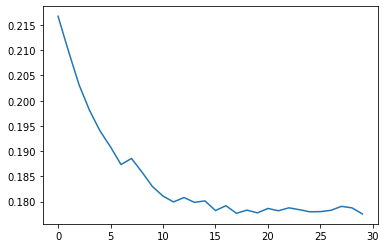

In [ ]:
plt.plot(training_error)

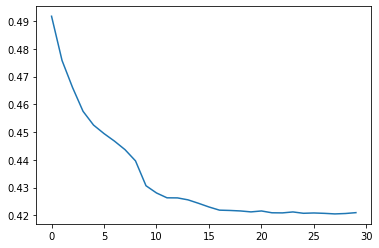

In [ ]:
# training_error.extend(training_error)
plt.plot(training_loss)

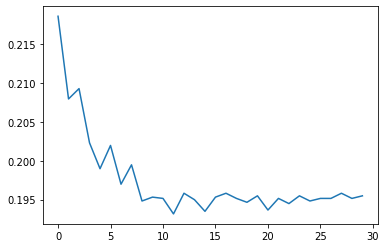

In [ ]:
plt.plot(val_error)

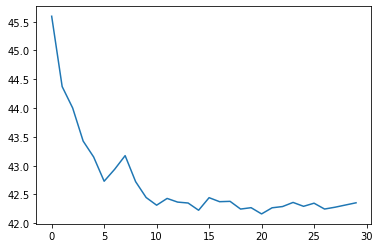

In [ ]:
plt.plot(val_loss)

# Two Layer LSTM

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
# Define RNN

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden = 150
        self.layers = 2
        self.lstm = nn.LSTM(input_size=48,hidden_size=self.hidden,num_layers=self.layers)
        self.linear = nn.Linear(self.hidden,2)
        self.relu = nn.ReLU()

    def forward(self, x, h, c):
        out,(h,c) = self.lstm(x,(h,c))
        
        out = self.linear(out)
        # out = self.relu(out)
        return out,h,c

    def init_h(self, bsz):
        weight = next(self.parameters())
        return weight.new_zeros(self.layers, self.hidden)

    def init_c(self, bsz):
        weight = next(self.parameters())
        return weight.new_zeros(self.layers, self.hidden)

Using cuda device


In [ ]:
# Define Loss, Optimizer
model2 = NeuralNetwork()
model2 = model2.to(device)
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=4,threshold=1e-3, factor=0.4)



In [ ]:
# Training 
batch_sz = CONSTANTS['batch_size']
data_size = len(data)
train_set, valid_set = random_split(data, [40000, 6728])

train_loader = DataLoader(train_set, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(valid_set, batch_size=batch_sz, shuffle=True)
# total_loader = DataLoader(data,batch_size = batch_sz, shuffle=True)

In [ ]:
def metrics(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    
    return torch.round(precision, decimals=3), torch.round(recall, decimals=3), torch.round(f1, decimals=3)

In [ ]:
# train_loader = total_loader

def train2():
  
  h = model2.init_h(batch_sz)
  c = model2.init_c(batch_sz)

  epochs = 25

  training_loss = []
  training_error = []
  training_precision = []
  training_recall = []
  training_f1 = []
  val_loss = []
  val_error = []
  val_precision = []
  val_recall = []
  val_f1 = []
  learning_rates = []
  for epoch in range(epochs):
    model2.train()
    start_time = time.time()
    running_loss = 0
    correct = 0
    flag = 0
    preds, targs = [], []

    for op_params in optimizer.param_groups:
      learning_rates.append(op_params['lr'])

    for input,label in train_loader:

        input = input.to(device)
        label = label.to(device)
        model2.zero_grad()
        h = h.detach()
        c = c.detach()
        output, h, c = model2(input, h, c)
        output = output.to(device)

        loss = criterion(output, label)

        _, pred = torch.max(output, 1)
        
        correct += (pred == label).float().sum().detach().cpu()
        loss.backward()

        preds.extend(list(pred.detach().cpu()))
        targs.extend(label.tolist())

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # torch.nn.utils.clip_grad_norm_(model2.parameters(), 0.2)
        optimizer.step()

        running_loss += loss.item()

        

    precision, recall, f1 = metrics(torch.tensor(preds), torch.tensor(targs))
    training_loss.append(running_loss/(len(train_loader)))
    training_error.append(1 - (correct/(len(train_loader)*batch_sz)))
    training_precision.append(precision)
    training_recall.append(recall)
    training_f1.append(f1)

    print('Epoch [{}/{}], Training Loss: {:.4f}, Training Error: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(epoch+1, epochs, running_loss/(len(train_loader)), 1 - (correct/(len(train_loader)*batch_sz)), precision, recall, f1))


    



  # # Calculate validation loss and error after each epoch

    model2.eval()
    val_correct = 0
    running_loss_val = 0

    val_preds, val_targs = [], []
   

    for input,label in test_loader:
      input = input.to(device)
      label = label.to(device)

      output, _, _ = model2(input, h, c)

      loss = criterion(output, label)
      _, pred = torch.max(output, 1)
      val_correct += (pred == label).float().sum().detach().cpu()

      running_loss_val += loss.item()

      val_preds.extend(list(pred.detach().cpu()))
      val_targs.extend(label.tolist())

    precision, recall, f1 = metrics(torch.tensor(val_preds), torch.tensor(val_targs))
    avg_loss = running_loss_val/len(test_loader)
    val_loss.append(avg_loss)
    val_error.append(1 - (val_correct/(len(test_loader)*batch_sz)))
    val_precision.append(precision)
    val_recall.append(recall)
    val_f1.append(f1)

    print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Error: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(epoch+1, epochs, avg_loss, 1 - (val_correct/(len(test_loader)*batch_sz)), precision, recall, f1))
    print("="*30)

    scheduler.step(avg_loss)

  return training_error, training_loss, training_precision, training_recall, training_f1, val_error, val_loss, val_precision, val_recall, val_f1, learning_rates



In [ ]:
training_error, training_loss, training_precision, training_recall, training_f1, val_error, val_loss, val_precision, val_recall, val_f1, learning_rates = train2()

<ipython-input-3-8e5964667ac5>:31: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.flatten(all_features), torch.tensor(label, dtype=torch.long)


Epoch [1/25], Training Loss: 0.3893, Training Error: 0.1749, Precision: 0.7560, Recall: 0.8770, F1: 0.8120
Epoch [1/25], Validation Loss: 0.3510, Validation Error: 0.1548, Precision: 0.7430, Recall: 0.9480, F1: 0.8330
Epoch [2/25], Training Loss: 0.3466, Training Error: 0.1491, Precision: 0.7780, Recall: 0.9110, F1: 0.8390
Epoch [2/25], Validation Loss: 0.3345, Validation Error: 0.1483, Precision: 0.7550, Recall: 0.9500, F1: 0.8420
Epoch [3/25], Training Loss: 0.3310, Training Error: 0.1392, Precision: 0.7890, Recall: 0.9210, F1: 0.8500
Epoch [3/25], Validation Loss: 0.3419, Validation Error: 0.1523, Precision: 0.7400, Recall: 0.9570, F1: 0.8350
Epoch [4/25], Training Loss: 0.3252, Training Error: 0.1386, Precision: 0.7930, Recall: 0.9190, F1: 0.8510
Epoch [4/25], Validation Loss: 0.3205, Validation Error: 0.1390, Precision: 0.7990, Recall: 0.9250, F1: 0.8570
Epoch [5/25], Training Loss: 0.3236, Training Error: 0.1368, Precision: 0.7940, Recall: 0.9220, F1: 0.8530
Epoch [5/25], Validat

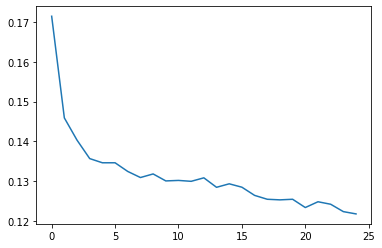

In [ ]:
plt.plot(training_error)

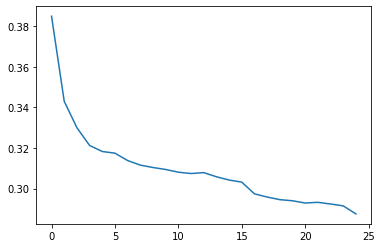

In [ ]:
# training_error.extend(training_error)
plt.plot(training_loss)

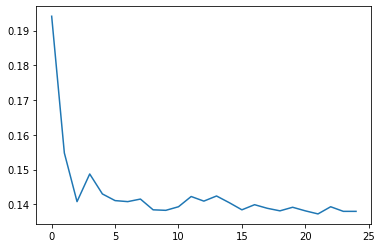

In [ ]:
plt.plot(val_error)

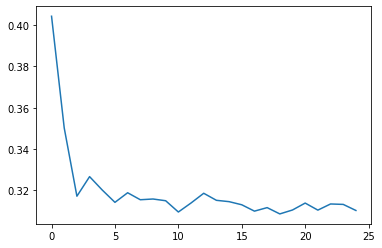

In [ ]:
plt.plot(val_loss)

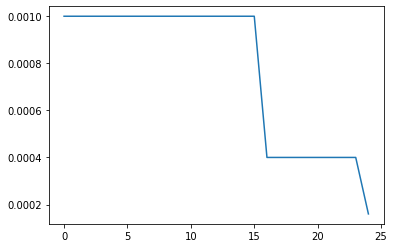

In [ ]:
plt.plot(learning_rates)